In [ ]:
#import all important libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

In [ ]:
def invert_colors(image):
    max_intensity = 255
    inverted_image = max_intensity - image
    return inverted_image


In [ ]:
def threshold_image(image, otsu=True):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's method to find the optimal threshold value
    if otsu:
        _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        # You can set a fixed threshold value if Otsu is not desired
        threshold_value =50
        _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    return thresholded_image


In [ ]:
def detect_salt_and_pepper_noise(image, kernel_size=3):

  # Apply median filter to denoise the image
  denoised_image = cv2.medianBlur(image, kernel_size)

  # Calculate the absolute difference between the original and denoised images
  diff = cv2.absdiff(image, denoised_image)

  # Set a threshold for pixel value difference
  threshold = 30  # Adjust this threshold as needed

  # Check if there is a significant difference
  if np.sum(diff > threshold) > 0:
      return True
  else:
      return False

def detect_shadow(hist):
    # Finding peaks in the histogram
    peaks, _ = find_peaks(hist, height=0)
    high_peaks = peaks[hist[peaks] >= 230]

    # Visualize the histogram with high peaks
    plt.figure(figsize=(10, 5))
    plt.plot(hist, color='black')
    plt.plot(high_peaks, hist[high_peaks], "x", color='red', markersize=10)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram with High Peaks')
    plt.show()


  # If there are at most 3 peaks
    if len(high_peaks) <= 3:
        # Checkiing if there are other peaks than the highest one
        if len(high_peaks) > 1:
            # Get the intensity values of the peaks
            peak_values = hist[high_peaks]

            # Getting the index of the highest peak
            highest_peak_index = np.argmax(peak_values)

            # Checking if all peak values are not more than 0.98 from the highest peak value
            if all(value / peak_values[highest_peak_index] < 0.98 for value in peak_values):
                return True
        else:
            # No other peaks than the highest one, then return true
            return True

    return False


def remove_shadow(image, hist):

    draw_hist(hist,'Histogram Before Shadow Removal')

    # Histogram stretching to remove shadows
    min_intensity = np.min(hist)
    max_intensity = np.max(hist)
    stretched_image = ((image - min_intensity) * (255 / (max_intensity - min_intensity))).astype(np.uint8)

    # Calculate the histogram after shadow removal
    stretched_hist, _ = np.histogram(stretched_image.flatten(), 256, [0, 256])

    draw_hist(stretched_hist,'Histogram After Shadow Removal')

    return stretched_image

def some_condition_based_on_histogram(cdf_normalized):
    threshold_percentage = 0.95
    return np.max(cdf_normalized) > threshold_percentage * cdf_normalized[-1]


In [ ]:
def draw_hist(hist,title):
  plt.figure(figsize=(10, 5))
  plt.plot(hist, color='black')
  plt.title(title)
  plt.show()

In [ ]:

def find_first_peak(hist):
    # Find indices of local maxima in the histogram
    peaks, _ = find_peaks(hist)

    # Return the index of the first peak from the left
    if len(peaks) > 0:
        return peaks[0]
    else:
        return None

def peak(image):

    # Calculate the histogram
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])

    # Find the index of the first peak from the left
    first_peak_index = find_first_peak(hist)

    if first_peak_index is not None:
        # Set a tolerance of 55 pixels around the first peak
        tolerance = 55
        start_index = max(0, first_peak_index - tolerance)
        end_index = min(255, first_peak_index + tolerance)

        # Set the intensities in the tolerance range to 0
        image[(image >= start_index) & (image <= end_index)] = 0

        # Find the maximum peak value intensity
        max_peak_index = np.argmax(hist)
        max_peak_intensity = bins[max_peak_index]

        # Set all non-zero pixels to the maximum peak intensity
        image[image > 0] = max_peak_intensity

        # Display the initial histogram
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(hist, color='black')
        plt.title('Initial Histogram')

        # Display the processed image
        plt.subplot(1, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title('Processed Image')

        # Display the resultant histogram
        hist_processed, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
        plt.subplot(1, 3, 3)
        plt.plot(hist_processed, color='black')
        plt.title('Resultant Histogram')

        plt.show()

        return image
    else:
        print("No peak found in the histogram.")
        return None

In [ ]:
def findContours(image,threshold_image):

  # Find contours in the grayscale image
  contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Display the original, thresholded, and contoured images using matplotlib
  plt.figure(figsize=(15, 5))

  # Contoured Image
  contoured_image = image.copy()
  cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 2)  # Draw contours on the original image
  plt.subplot(1, 3, 1)
  plt.imshow(contoured_image, cmap='gray')
  plt.title('Contoured Image')

  plt.show()
  return contoured_image,contours

In [ ]:
def findConnectComponentBoundary(image,thresholded_image,contours):

  # Create a mask image with the same size as the grayscale image
  mask = np.zeros_like(thresholded_image)

  # Draw contours on the mask
  cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

  # Find connected components in the mask
  num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

  # Filter components at the boundary
  boundary_components = []
  image_height, image_width = thresholded_image.shape

  for label in range(1, num_labels):
      left, top, width, height, area = stats[label]

      # Check if the component is at the boundary (you can adjust the threshold as needed)
      if left <= 1 or top <= 1 or left + width >= image_width - 1 or top + height >= image_height - 1:
          boundary_components.append(label)

  # Highlight boundary components on the original image
  boundary_highlighted_image = image.copy()
  for label in boundary_components:
      mask = np.where(labels == label, 255, 0).astype(np.uint8)
      contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(boundary_highlighted_image, contours, -1, (0, 0, 255), thickness=2)

  # Display the original, grayscale, and boundary highlighted images
  plt.figure(figsize=(15, 5))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')

  # Grayscale Image
  plt.subplot(1, 3, 2)
  plt.imshow(thresholded_image, cmap='gray')
  plt.title('Grayscale Image')

  # Boundary Highlighted Image
  plt.subplot(1, 3, 3)
  plt.imshow(cv2.cvtColor(boundary_highlighted_image, cv2.COLOR_BGR2RGB))
  plt.title('Boundary Highlighted Image')

  plt.show()
  return boundary_highlighted_image,boundary_components,labels

In [ ]:
def remove_boundary_contour (image,thresholded_image,boundary_components,labels):

  # Create a mask for boundary components
  boundary_mask = np.zeros_like(thresholded_image)

  for label in boundary_components:
      mask = np.where(labels == label, 255, 0).astype(np.uint8)
      boundary_mask = cv2.bitwise_or(boundary_mask, mask)

  # Remove boundary components from the original image
  image_without_boundary_components = cv2.bitwise_and(image, image, mask=~boundary_mask)


  # Display the original, grayscale, boundary highlighted, and modified images
  plt.figure(figsize=(20, 5))# Remove boundary components from the grayscale image
  gray_image_without_boundary = cv2.bitwise_and(thresholded_image, thresholded_image, mask=~boundary_mask)

  # Original Image
  plt.subplot(1, 4, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')

  # Grayscale Image
  plt.subplot(1, 4, 2)
  plt.imshow(thresholded_image, cmap='gray')
  plt.title('Grayscale Image')

  # Modified Image without Boundary Components
  plt.subplot(1, 4,3)
  plt.imshow(cv2.cvtColor(image_without_boundary_components, cv2.COLOR_BGR2RGB))
  plt.title('Image without Boundary Components')

   # Modified Image without Boundary Components
  plt.subplot(1, 4,3)
  plt.imshow(cv2.cvtColor(gray_image_without_boundary , cv2.COLOR_BGR2RGB))
  plt.title('Boundary Component removed')


  plt.show()

  return gray_image_without_boundary

In [ ]:
def getBiggestContour(image,gray_image_without_boundary):

  # Find connected components in the grayscale image without boundary components
  num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gray_image_without_boundary, connectivity=8)

  # Find the label of the largest connected component (excluding background label 0)
  largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

  # Create a mask for the largest connected component
  largest_component_mask = np.where(labels == largest_component_label, 255, 0).astype(np.uint8)

  # Keep only the largest connected component in the grayscale image
  gray_image_largest_component = cv2.bitwise_and(gray_image_without_boundary, gray_image_without_boundary, mask=largest_component_mask)

  # Display the original, grayscale, boundary highlighted, and modified images
  plt.figure(figsize=(20, 5))

  # Original Image
  plt.subplot(1, 4, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')

  # Grayscale Image without Boundary Components
  plt.subplot(1, 4, 2)
  plt.imshow(gray_image_largest_component, cmap='gray')
  plt.title('Grayscale Image with Largest Connected Component')

  plt.show()

  return gray_image_largest_component

In [ ]:
def preprocessing(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img=image.copy()
    hist, _ = np.histogram(gray.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    if detect_salt_and_pepper_noise(gray):
        gray = cv2.medianBlur(gray, 5)

    elif detect_shadow(hist):
        gray = remove_shadow(gray, hist)

    elif some_condition_based_on_histogram(cdf_normalized):
        gray = cv2.equalizeHist(gray)

    # Additional preprocessing steps...
    # Apply dilation
    kernel_dilate = np.ones((7, 7), np.uint8)
    gray = cv2.dilate(gray, kernel_dilate, iterations=1)

    # Apply erosion
    kernel_erode = np.ones((1, 1), np.uint8)
    gray = cv2.erode(gray, kernel_erode, iterations=3)

    inverted_image = invert_colors(gray)

    thresholded_image =threshold_image( inverted_image,otsu=False)

    contoured_image,contours=findContours(gray,thresholded_image)

    boundary_highlighted_image,boundary_components,labels=findConnectComponentBoundary(img,thresholded_image,contours)

    gray_image_without_boundary= remove_boundary_contour (img,thresholded_image,boundary_components,labels)

    gray_image_largest_component=getBiggestContour(img,gray_image_without_boundary)

    # Dilation and Erosion
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Dilation
    gray_image_dilated = cv2.dilate(gray_image_largest_component, kernel, iterations=1)

    # Erosion
    gray_image_processed = cv2.erode(gray_image_dilated, kernel, iterations=1)

    # Display the original, grayscale, boundary highlighted, and processed images
    plt.figure(figsize=(20, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    # Boundary Highlighted Image
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(gray_image_largest_component, cv2.COLOR_BGR2RGB))
    plt.title('Boundary Highlighted Image')

    # Processed Image (Dilation and Erosion)
    plt.subplot(1, 4, 3)
    plt.imshow(gray_image_processed, cmap='gray')
    plt.title('Processed Image (Dilation and Erosion)')
    return gray_image_processed



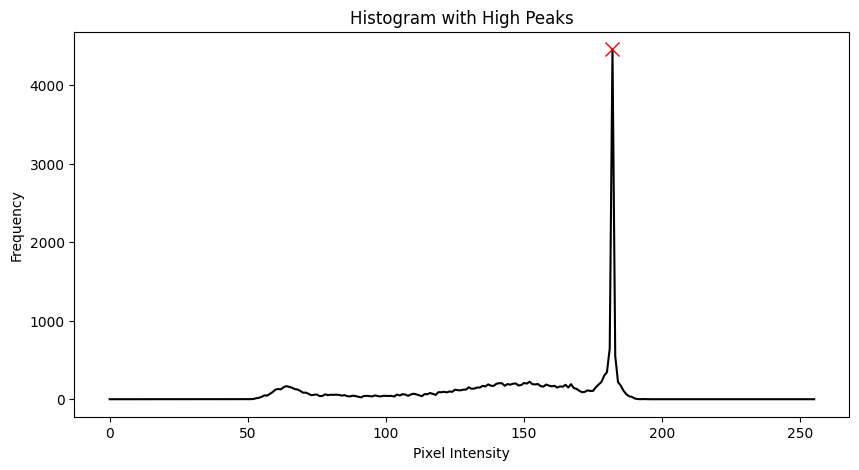

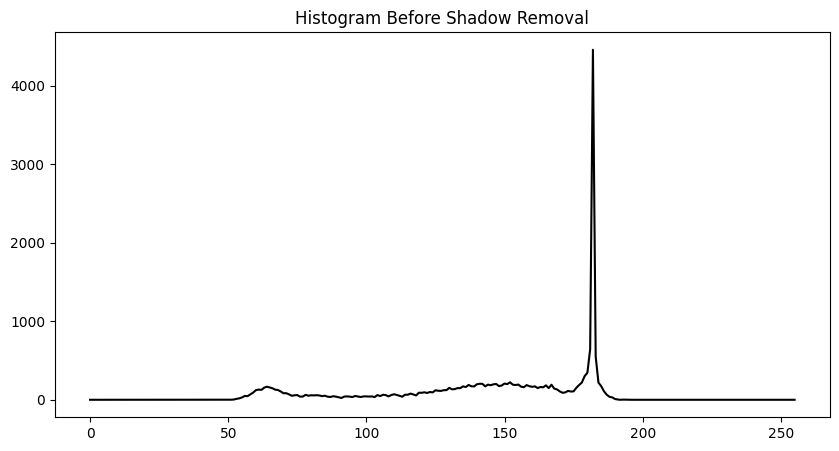

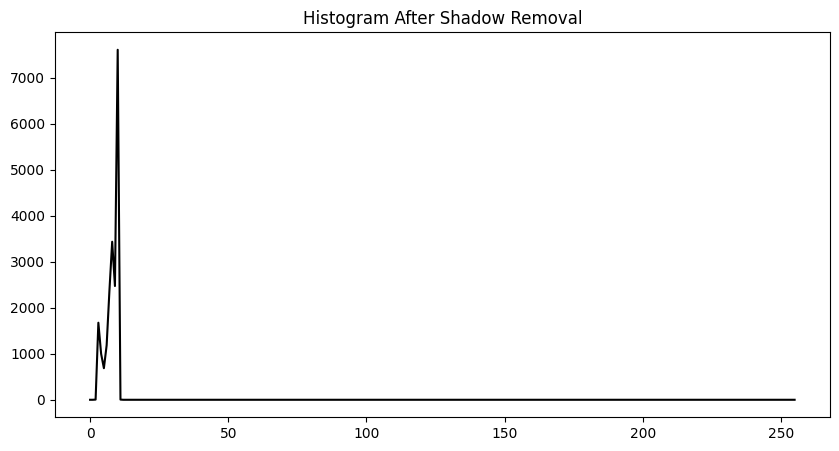

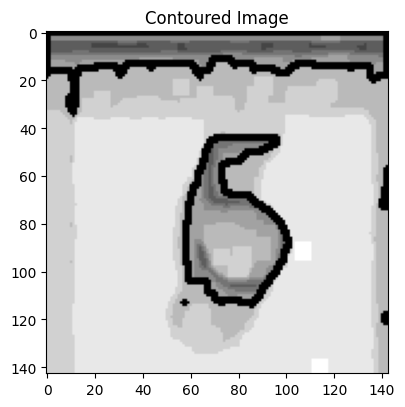

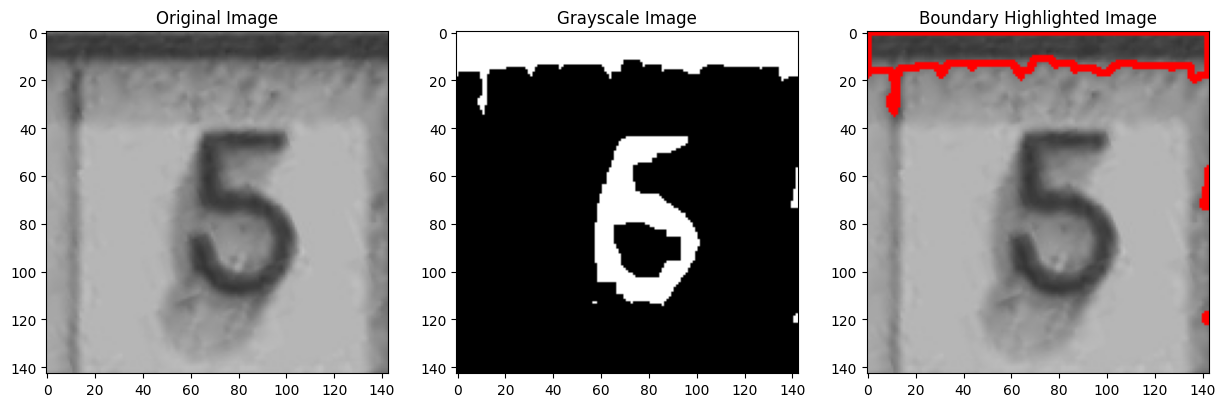

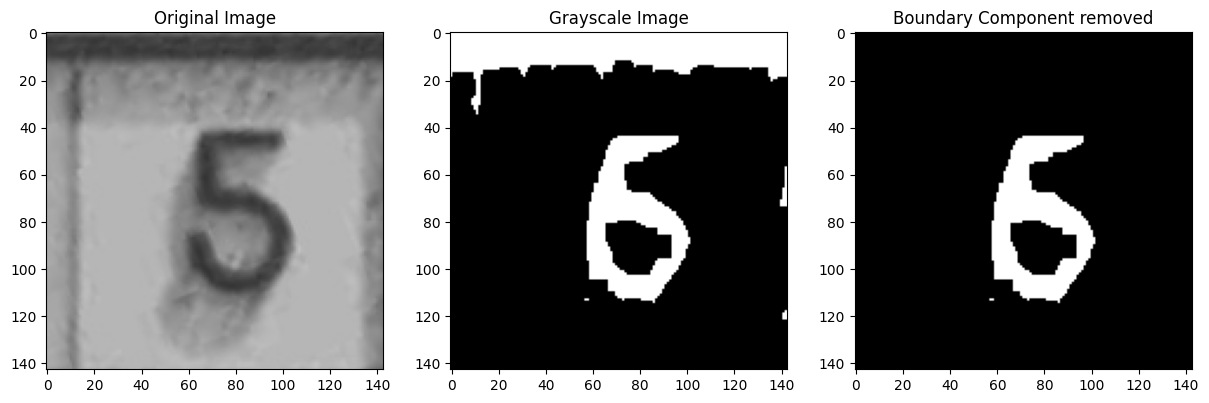

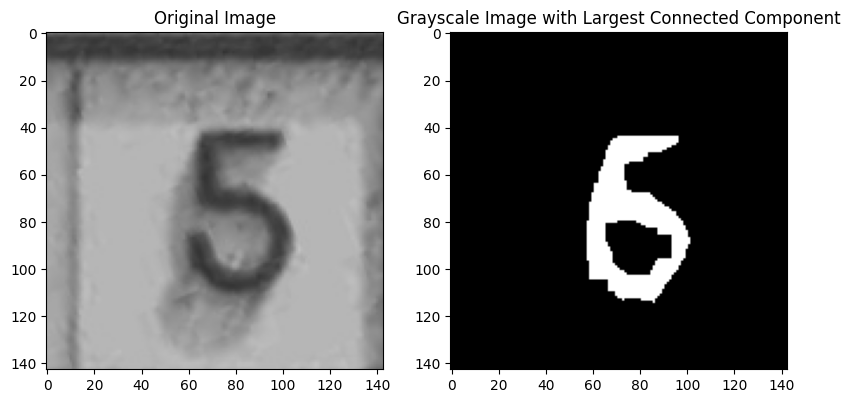

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

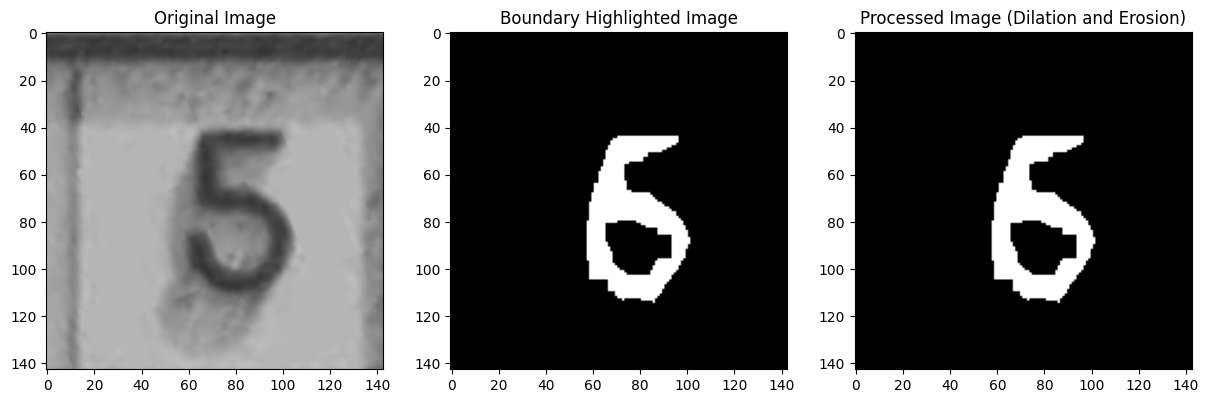

In [ ]:
image=cv2.imread('5.jpg')
preprocessing(image)

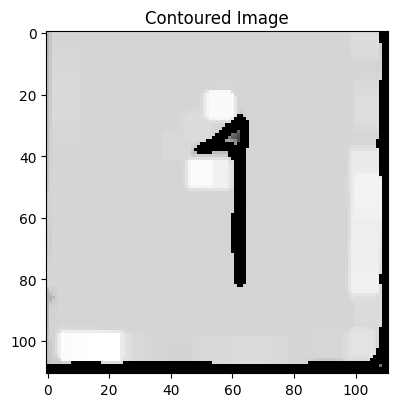

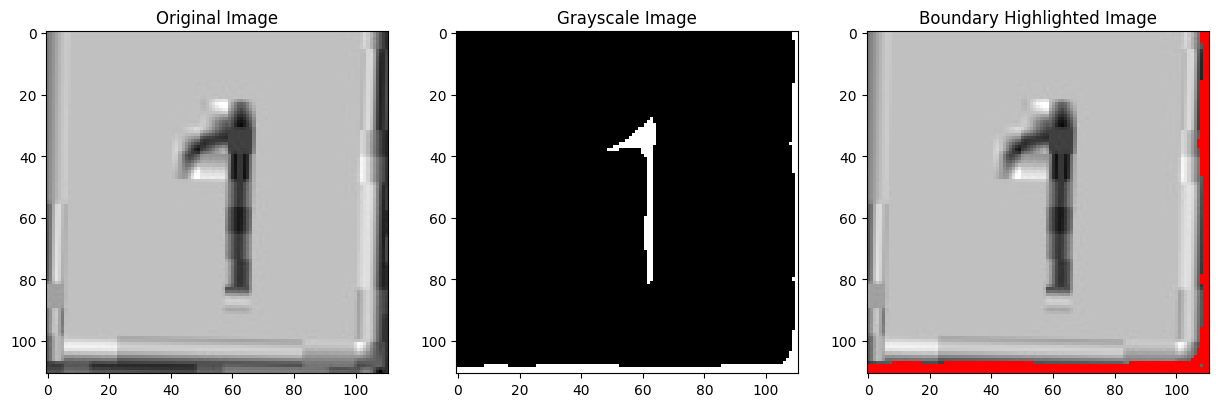

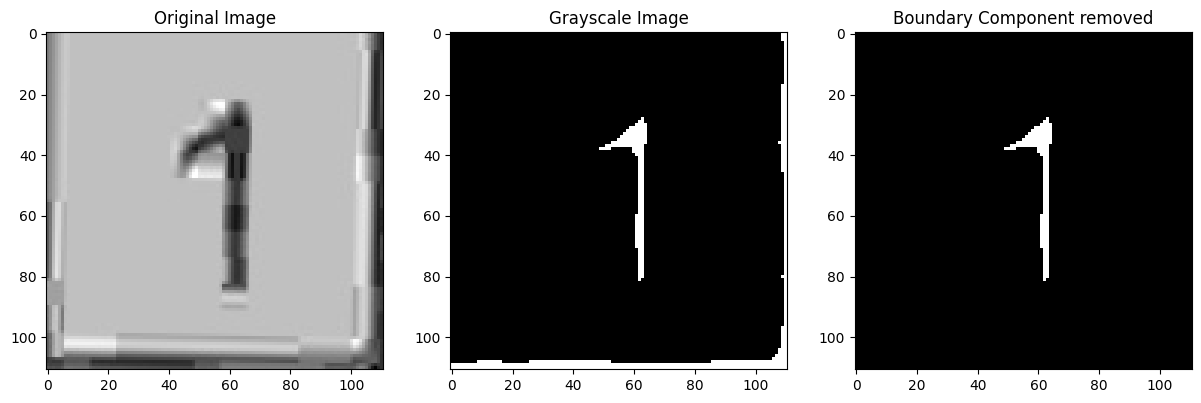

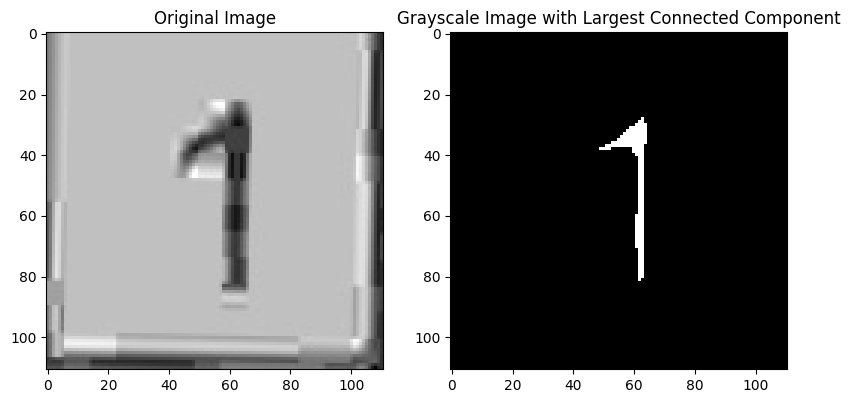

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

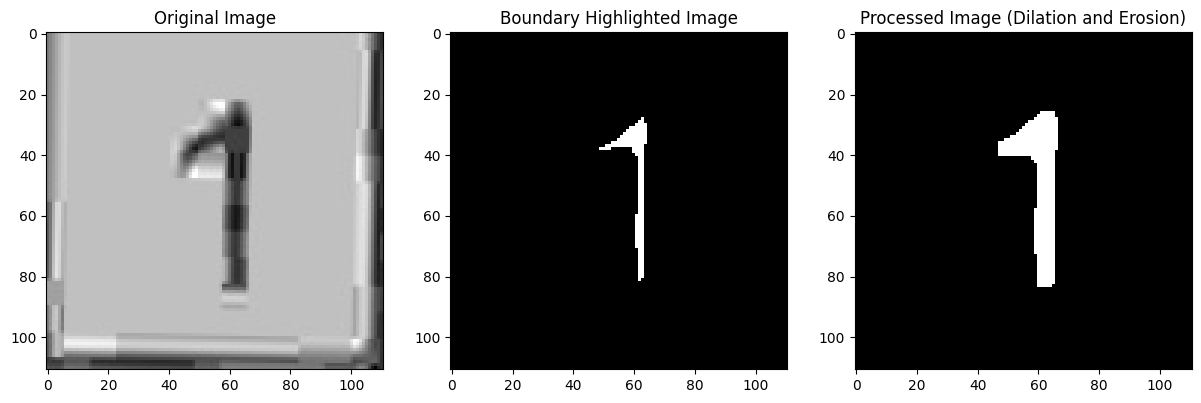

In [ ]:
image=cv2.imread('1_espresso.jpg')
preprocessing(image)

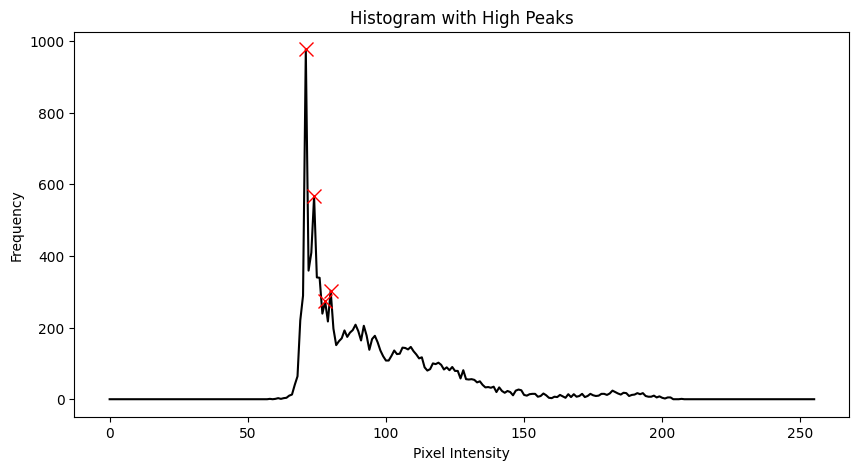

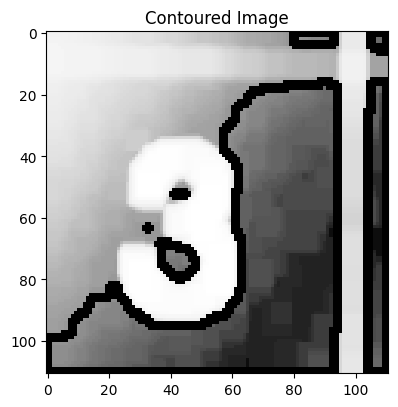

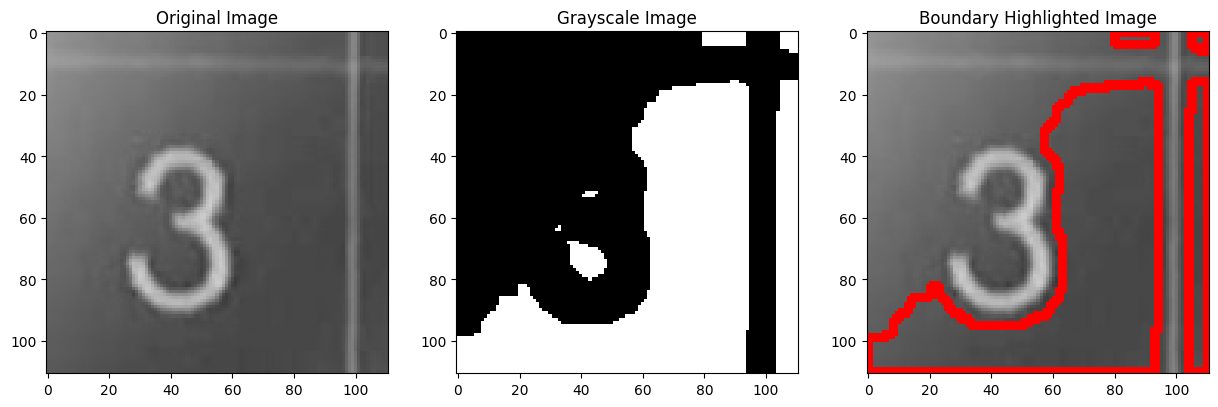

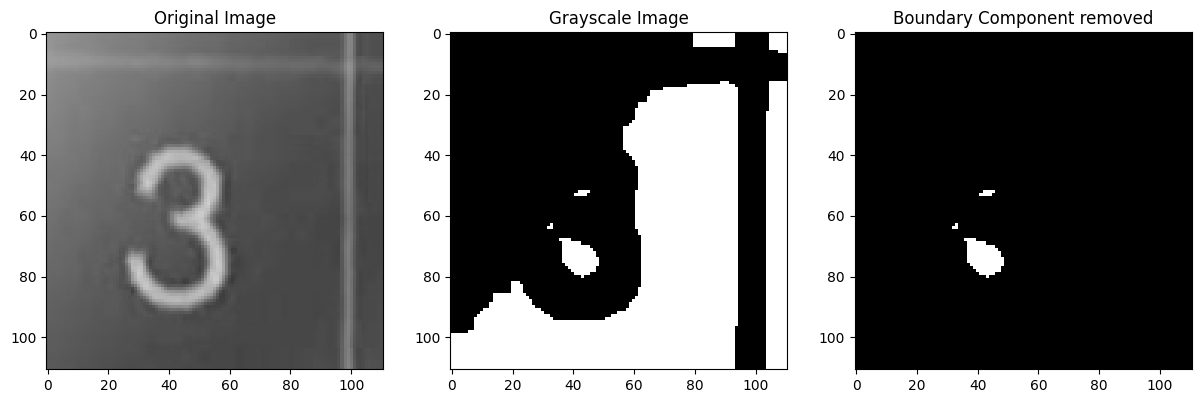

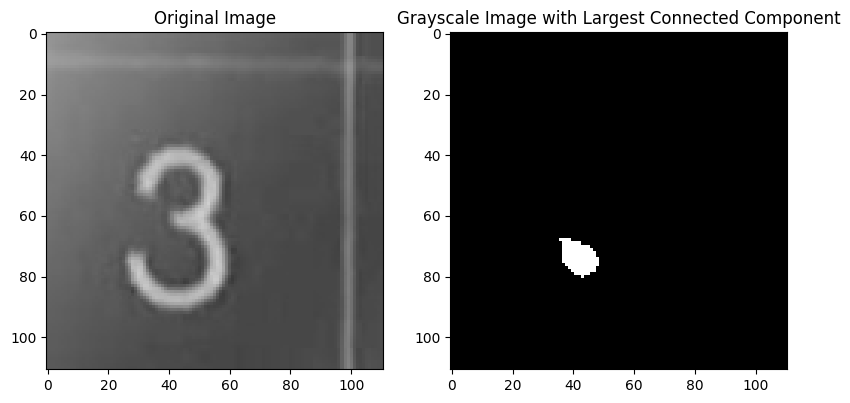

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

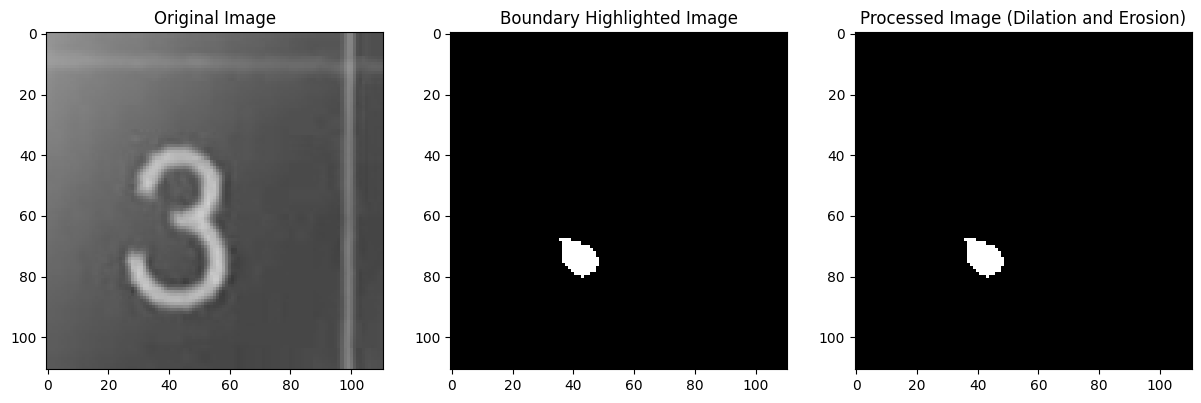

In [ ]:
image=cv2.imread('3sine.jpg')
preprocessing(image)